In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.prediction.VAE import ConditionalVAE
from utils.datasets import MNIST_SR
from utils.utils import gaussian_kl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 20
batch_size = 512
scalefactor = 2

latent_dims = [64]
condition_dims = [32, 64]
channels = [16, 32, 64, 128]
cond_channels = [16, 32]
in_channels = 1
cond_base_width = 16
model = ConditionalVAE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          cond_channels=cond_channels,
                          condition_dims=condition_dims,
                          cond_base_width=cond_base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, cond_base_width, cond_base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, 32, 32), (1, in_channels, cond_base_width, cond_base_width)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [1, 1, 32, 32]            --
├─ConditionalVAEEncoder: 1-1             [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           32
│    └─Conv2d: 2-2                       [1, 32, 16, 16]           8,224
│    └─Conv2d: 2-3                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-4                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-5                       [1, 64]                   131,136
│    └─Linear: 2-6                       [1, 64]                   131,136
├─ConditionalVAELREncoder: 1-2           [1, 32]                   --
│    └─Conv2d: 2-7                       [1, 16, 16, 16]           32
│    └─Conv2d: 2-8                       [1, 32, 8, 8]             8,224
│    └─Linear: 2-9                       [1, 32]                   65,568
│    └─Linear: 2-10                      [1, 64]        

In [3]:
train_dataset = MNIST_SR(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [5]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)
from piq import ssim
criterion = lambda a,b: -1* ssim(a,b)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
loss_list = []
recon_loss_list = []
kl_loss_list = []

In [ ]:
kl_weight = 100

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    for HR, LR in train_loader:
        optimizer.zero_grad()

        recon_imgs, latents = model(HR, LR)

        recon_loss = criterion(recon_imgs, HR)
        kl_loss = 0
        for mu, logvar in latents:
            kl_loss += torch.mean(gaussian_kl(mu, logvar, torch.zeros_like(mu), torch.zeros_like(logvar)))
        loss = recon_loss + kl_weight * kl_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    scheduler.step()    

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.6f} | Recon Loss: {total_recon_loss:.6f} | KL Loss: {total_kl_loss:.6f}")
    loss_list.append(total_loss)
    recon_loss_list.append(total_recon_loss)
    kl_loss_list.append(total_kl_loss)

Epoch [1/20] | Loss: -107.953888 | Recon Loss: -107.966906 | KL Loss: 0.000130
Epoch [2/20] | Loss: -108.653513 | Recon Loss: -108.664991 | KL Loss: 0.000115
Epoch [3/20] | Loss: -109.235892 | Recon Loss: -109.246080 | KL Loss: 0.000102
Epoch [4/20] | Loss: -109.758465 | Recon Loss: -109.767536 | KL Loss: 0.000091
Epoch [5/20] | Loss: -110.209143 | Recon Loss: -110.217256 | KL Loss: 0.000081
Epoch [6/20] | Loss: -110.608463 | Recon Loss: -110.615753 | KL Loss: 0.000073
Epoch [7/20] | Loss: -110.954030 | Recon Loss: -110.960612 | KL Loss: 0.000066
Epoch [8/20] | Loss: -111.275970 | Recon Loss: -111.281930 | KL Loss: 0.000060
Epoch [9/20] | Loss: -111.549435 | Recon Loss: -111.554866 | KL Loss: 0.000054


KeyboardInterrupt: 

In [ ]:
path = f"saves/VAE_MNIST_SR_c{scalefactor}x_losses.pth"
torch.save(model.state_dict(), path)

In [ ]:
model.load_state_dict(torch.load(path))

[]

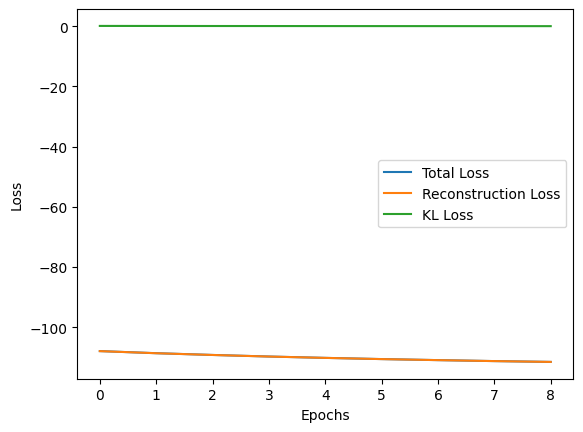

In [17]:
plt.plot(loss_list, label='Total Loss')
plt.plot(recon_loss_list, label='Reconstruction Loss')
plt.plot([l * kl_weight * 10 for l in kl_loss_list], label='KL Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [18]:
HR, LR = test_dataset.get_samples(320)
SR = model.sample(LR)

In [19]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

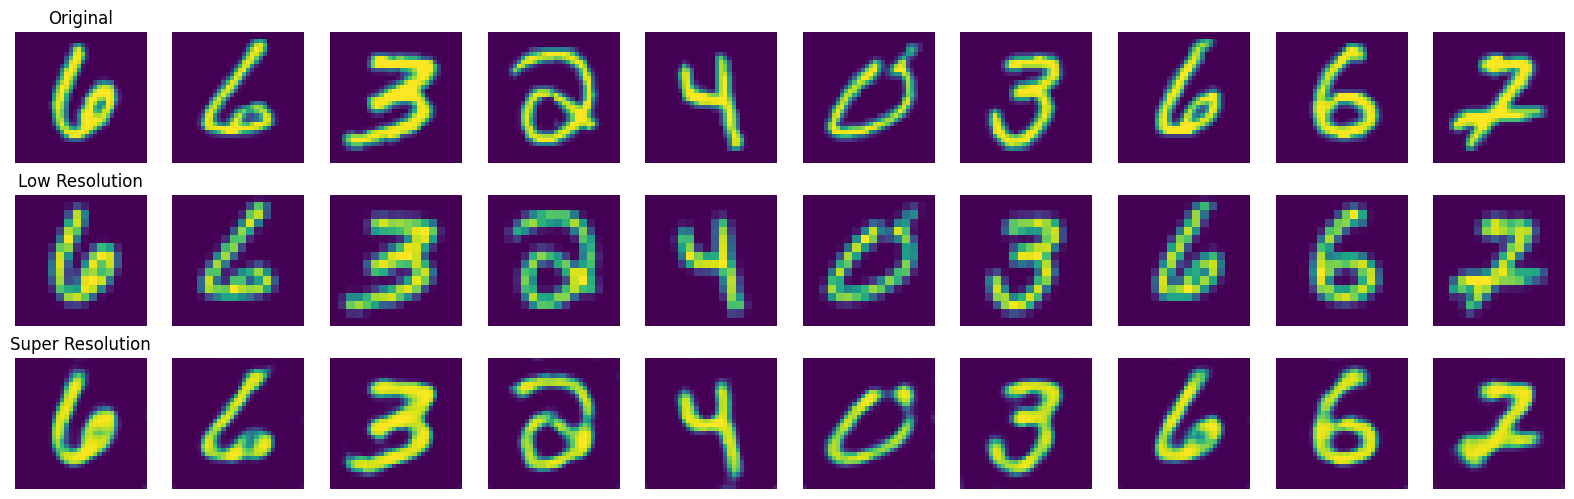

In [20]:
show_image(HR, LR, SR, 10)

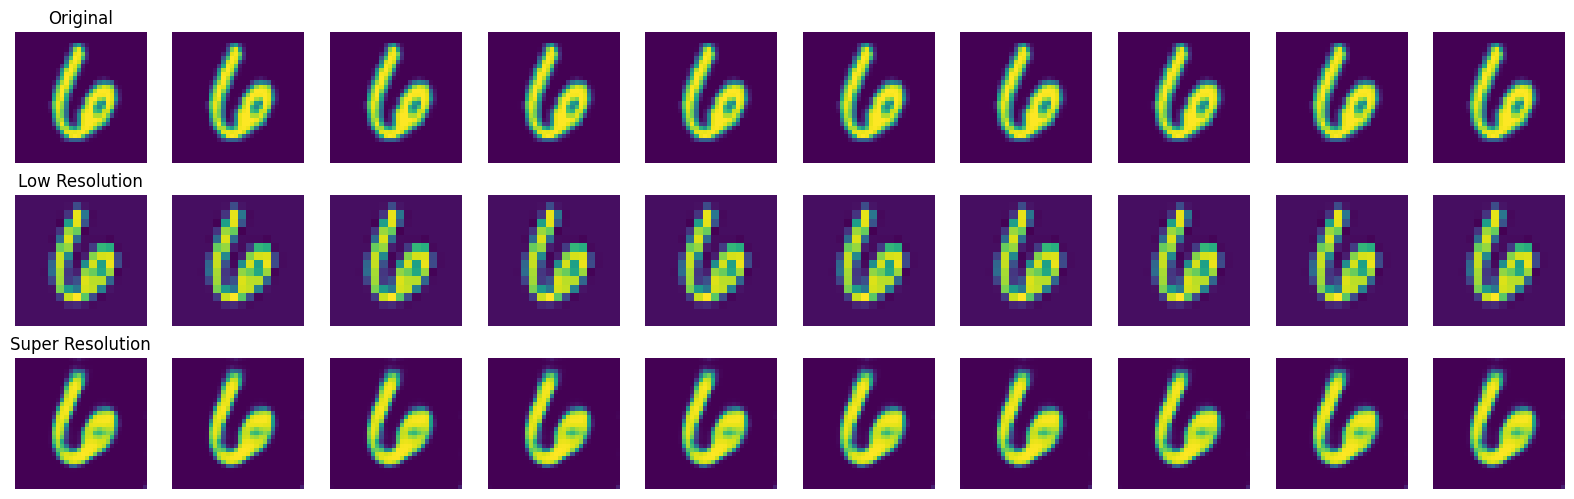

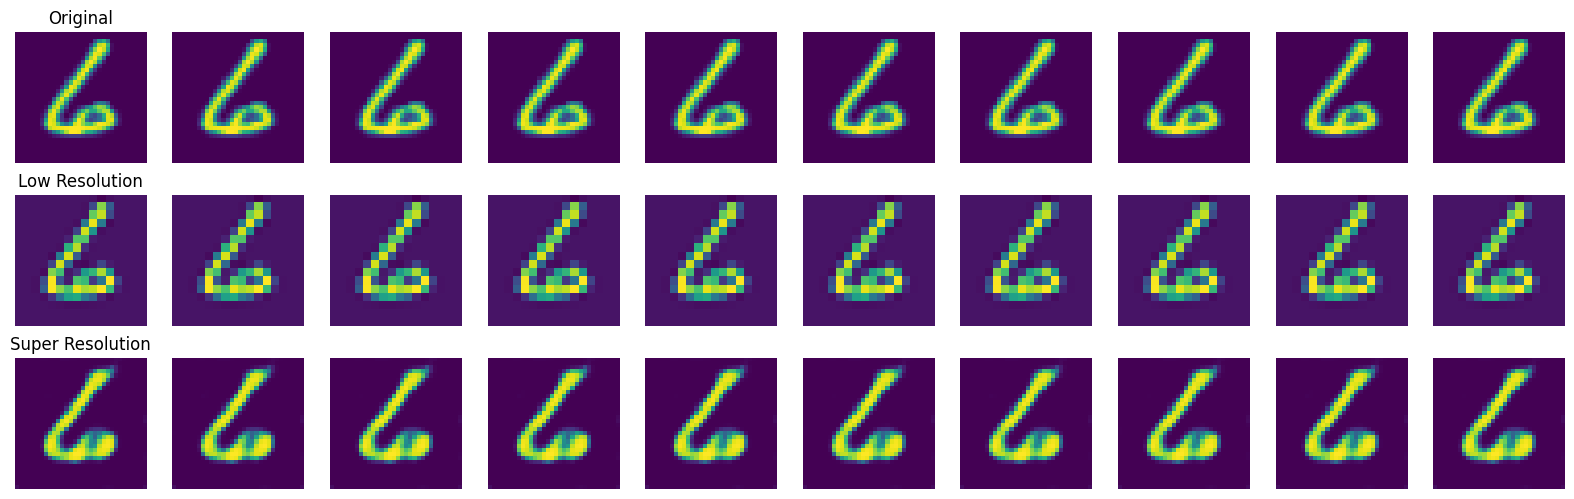

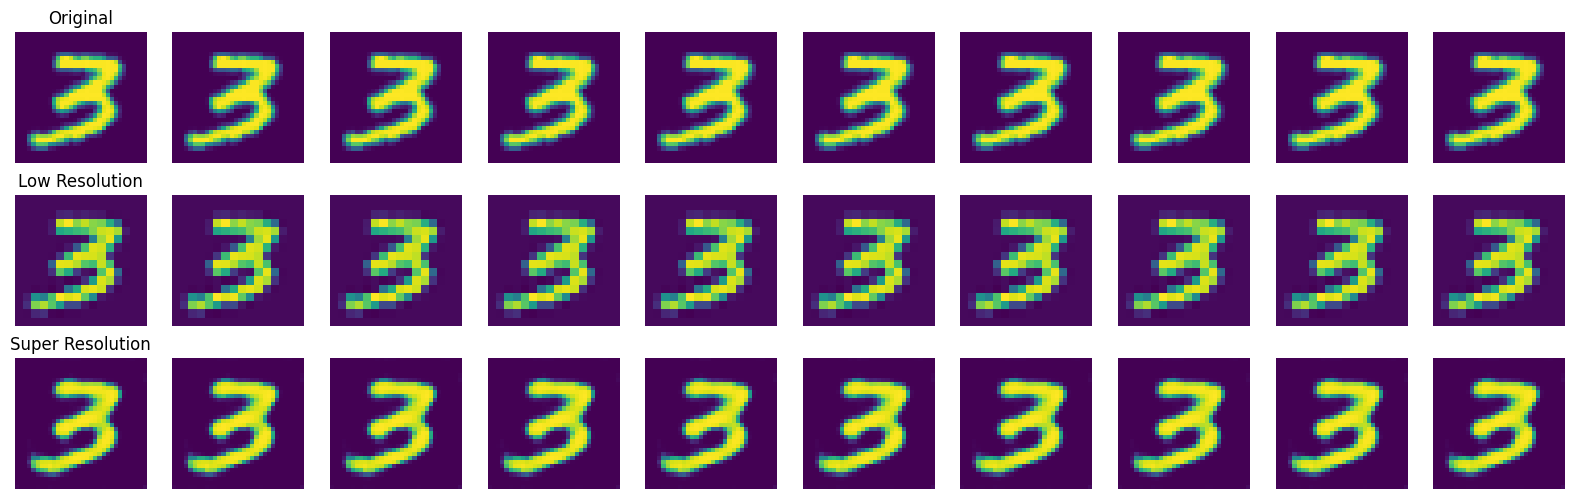

In [21]:
n_samp = 3

for i in range(n_samp):
    reference = HR[i]
    reference = reference.repeat(batch_size, 1, 1, 1)
    reference_inp = torch.nn.functional.interpolate(reference, size=(cond_base_width, cond_base_width), mode='bicubic', align_corners=False)
    
    samples = model.sample(reference_inp).detach().cpu()

    show_image(reference, reference_inp, samples, 10)

In [22]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PSNR: 24.7379207611084
SSIM: 0.9496176838874817
LPIPS: 0.046066764742136
BRISQUE: 98.25817108154297
PSNR Consistency: 33.683753967285156
MSE Diversity: 1.2625738069260706e-05
LPIPS Diversity: 0.00015435645997285974
